326


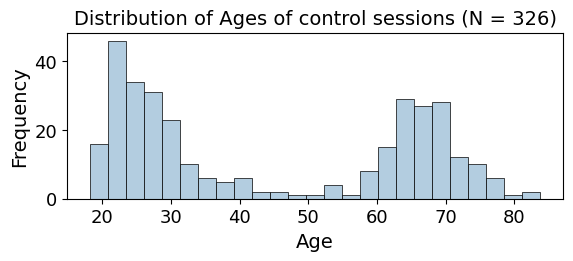

In [33]:
import os
import pandas as pd
base_path = '/Users/dennis.jungchildmind.org/Desktop/omega'
session_file = 'sessions.tsv'

sessions = pd.read_csv(os.path.join(base_path, session_file), sep='\t')

sessions.head()

coregistered_control_sessions = sessions[
    (sessions['coregistration'].str.lower() == 'yes') &
    (sessions['group'].str.lower() == 'control')
]

#check how many sessions are coregistered
print(len(coregistered_control_sessions))

#show distribution of ages
ax = coregistered_control_sessions['age'].hist(
    bins=25, 
    grid=False, 
    edgecolor='black',
    facecolor='#b3cde0',  # pastel blue
    linewidth=0.5
)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title(f'Distribution of Ages of control sessions (N = {len(coregistered_control_sessions)})', fontsize=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_aspect(aspect=1/2)





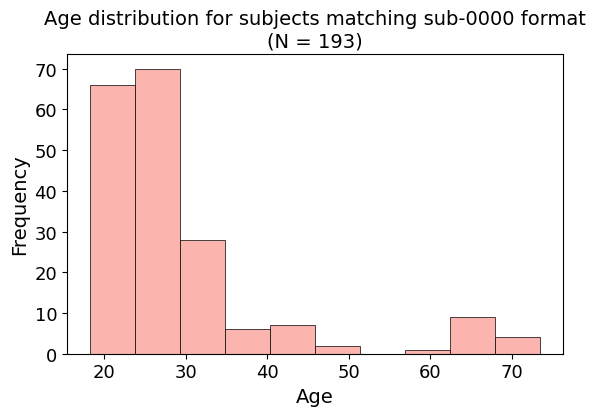

In [70]:
import re

# Filter the DataFrame for subjects matching the pattern 'sub-0000' where 0000 are digits
pattern = r'^sub-\d{4}$'
matched_sub_sessions = coregistered_control_sessions[
    coregistered_control_sessions['participant_id'].str.match(pattern)
]

# Plot the age distribution for these subjects
ax = matched_sub_sessions['age'].hist(
    bins=10,
    grid=False,
    edgecolor='black',
    facecolor='#fbb4ae',  # pastel pink
    linewidth=0.5
)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title(f'Age distribution for subjects matching sub-0000 format\n(N = {len(matched_sub_sessions)})', fontsize=14)
ax.tick_params(axis='both', labelsize=13)
ax.set_aspect(aspect=1/2)


In [ ]:
import os
import subprocess


# Set the full path to rclone binary
rclone_path = '/Users/dennis.jungchildmind.org/Downloads/rclone-v1.72.1-osx-arm64/rclone'

# Set your preferred root target directory for downloads 
target_base_dir = "/Users/dennis.jungchildmind.org/Downloads/test/"  # or set to any path you want

nii_gz_paths = []   # Will store all remote paths to .nii.gz
t1w_json_paths = [] # Will store all remote paths to _T1w.json

for idx, row in coregistered_control_sessions.iterrows():
    sub_id = row['participant_id']
    remote_base = f"omega:Omega/{sub_id}"
    local_base = os.path.join(target_base_dir, sub_id)

    # List all files under this subject directory
    cmd_ls = f'"{rclone_path}" ls {remote_base}'
    print(f"Listing files: {cmd_ls}")
    result = subprocess.run(cmd_ls, shell=True, check=True, capture_output=True, text=True)
    lines = [line.strip().split(maxsplit=1)[1]
         for line in result.stdout.strip().split('\n')
         if len(line.strip().split(maxsplit=1)) == 2]

    found_any = False
    found_any_json = False
    for line in lines:
        remote_file = line.strip()
        remote_file_path = f"{remote_base}/{remote_file}"
        local_file_path = os.path.join(target_base_dir, sub_id, remote_file)
        local_file_dir = os.path.dirname(local_file_path)
        if remote_file.endswith('.nii.gz'):
            found_any = True
            nii_gz_paths.append(remote_file_path)
            print(f"[DOWNLOAD] Downloading nii.gz:\n"
                  f"  Remote file: {remote_file_path}\n"
                  f"  To local: {local_file_path}")
            # Make sure the local directory exists
            os.makedirs(local_file_dir, exist_ok=True)
            # Download the file, preserving structure
            cmd_copy = f'"{rclone_path}" copyto "{remote_file_path}" "{local_file_path}"'
            print(f"  Running: {cmd_copy}")
            subprocess.run(cmd_copy, shell=True, check=True)
        if remote_file.endswith('_T1w.json'):
            found_any_json = True
            t1w_json_paths.append(remote_file_path)
            print(f"[DOWNLOAD] Downloading _T1w.json:\n"
                  f"  Remote file: {remote_file_path}\n"
                  f"  To local: {local_file_path}")
            os.makedirs(local_file_dir, exist_ok=True)
            cmd_copy = f'"{rclone_path}" copyto "{remote_file_path}" "{local_file_path}"'
            print(f"  Running: {cmd_copy}")
            subprocess.run(cmd_copy, shell=True, check=True)
    if not found_any:
        print(f"[CHECK] No nii.gz found for subject {sub_id}")
    if not found_any_json:
        print(f"[CHECK] No _T1w.json found for subject {sub_id}")

print("All downloaded .nii.gz remote paths:")
for path in nii_gz_paths:
    print(path)

print("All downloaded _T1w.json remote paths:")
for path in t1w_json_paths:
    print(path)


    participant_id session    group    age coregistration  coreg_confidence
0         sub-0001  ses-01  Control  42.78            Yes               2.0
3         sub-0002  ses-02  Control  23.26            Yes               1.0
7         sub-0003  ses-02  Control  35.13            Yes               2.0
11        sub-0004  ses-02  Control  27.42            Yes               2.0
13        sub-0006  ses-01  Control  30.29            Yes               2.0
..             ...     ...      ...    ...            ...               ...
746     sub-PD1566  ses-01  Control  68.15            Yes               1.0
747     sub-PD1578  ses-01  Control  68.62            Yes               1.0
773     sub-PD1738  ses-01  Control  39.00            Yes               3.0
775     sub-PD1746  ses-02  Control  56.24            Yes               2.0
778     sub-PD1755  ses-02  Control  63.53            Yes               2.0

[326 rows x 6 columns]
